In [1]:
using DifferentialEquations, Plots, PlotThemes, CSV, DataFrames
using DiffEqParamEstim, Optim
theme(:juno)

In [2]:
df = CSV.read("data/owid-covid-data.csv")
head(df)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed
,String?,String?,String,Date…,Float64?,Float64?,Float64?
1,AFG,Asia,Afghanistan,2019-12-31,missing,0.0,missing
2,AFG,Asia,Afghanistan,2020-01-01,missing,0.0,missing
3,AFG,Asia,Afghanistan,2020-01-02,missing,0.0,missing
4,AFG,Asia,Afghanistan,2020-01-03,missing,0.0,missing
5,AFG,Asia,Afghanistan,2020-01-04,missing,0.0,missing
6,AFG,Asia,Afghanistan,2020-01-05,missing,0.0,missing


In [20]:
println(names(df))

["iso_code", "continent", "location", "date", "total_cases", "new_cases", "new_cases_smoothed", "total_deaths", "new_deaths", "new_deaths_smoothed", "total_cases_per_million", "new_cases_per_million", "new_cases_smoothed_per_million", "total_deaths_per_million", "new_deaths_per_million", "new_deaths_smoothed_per_million", "total_tests", "new_tests", "total_tests_per_thousand", "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand", "tests_per_case", "positive_rate", "tests_units", "stringency_index", "population", "population_density", "median_age", "aged_65_older", "aged_70_older", "gdp_per_capita", "extreme_poverty", "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", "male_smokers", "handwashing_facilities", "hospital_beds_per_thousand", "life_expectancy", "human_development_index"]


In [3]:
countries = ["Netherlands", "United Kingdom", "Italy"]
data = Dict()

for country in countries
    df_country = df[df["location"] .== country, "total_cases"]
    df_country = df_country[50:end] # remove first 50 days (no cases here)
    data[country] = df_country
end

In [161]:
function SEIRS(u, p, t)
    S, E, I, R = u
    β, σ, γ, ν, ξ = p
    
    [-β*I*S + ξ*R,
    β*S*I - σ*E,
    σ*E - γ*I,
    γ*I - ξ*R]
end

model(u, p, t) = SEIRS(u, [p[1], σ, γ, ν, ξ], t)

R₀(β, σ, ν) = β/(σ + ν)

R₀ (generic function with 1 method)

In [196]:
ν = 0.01    # death from infection
ξ = 1.0/120 # immunity loss
σ = 1/6
γ = 1/11

N_init = 1.6e5
S0 = (N_init-1)/N_init
E0 = 1/N_init
I0 = 0
R0 = 0

p = [1.0]

tspan = (0.0, 50.0)
u0 = [S0, E0, I0, R0]

prob = ODEProblem(model, u0, tspan, p, saveat=t)

fit_data = data["United Kingdom"][1:50]/N_init;
#plot(fit_data)

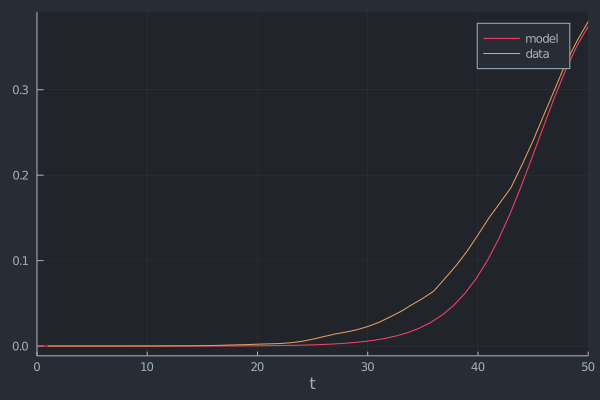

In [202]:
sol = solve(prob)
plot(sol, vars=(0, 3), label="model")
plot!(fit_data, label="data")

In [180]:
t = collect(range(0,stop=50,length=length(fit_data)))
function loss(sol)
   tot_loss = 0.0
   if any((s.retcode != :Success for s in sol))
     tot_loss = Inf
   else
     tot_loss = sum((sol[3,:] - fit_data).^2)/length(fit_data)
   end
   tot_loss
end

loss (generic function with 1 method)

In [207]:

cost_function = build_loss_objective(prob, Tsit5(), loss, verbose=true)

result = optimize(cost_function, lower, upper, p)
params = result.minimizer

1-element Array{Float64,1}:
 1.0345400754699543

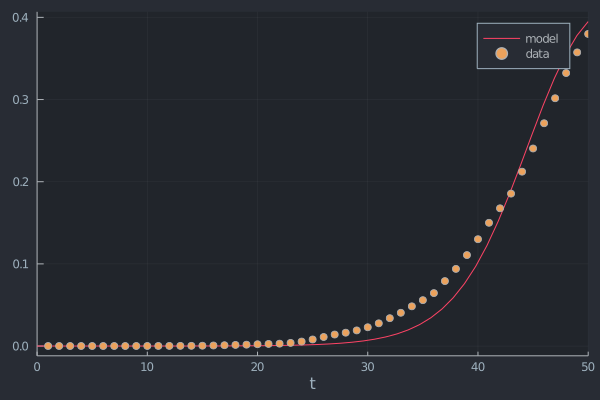

In [208]:
best_sol = solve(remake(prob, p=params));
plot(best_sol, vars=(0, 3), label="model")
scatter!(fit_data, label="data")

In [187]:
R₀(params[1], σ, ν)

4.139475315706574

In [210]:
function curve_fit(model, u0, tspan, p, xdata, ydata)
    upper = [20] # upper bound for Β
    lower = [0]  # lower bound for Β
    prob = ODEProblem(model, u0, tspan, p, saveat=xdata)
    cost_function = build_loss_objective(prob, Tsit5(), loss, verbose=true)
    result = optimize(cost_function, lower, upper, p)
    params = result.minimizer
    return params, remake(prob, p=params)
end

curve_fit (generic function with 1 method)